In [0]:
import numpy as np

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [0]:
import os
import numpy as np
import tensorflow as tf
import random
from unittest.mock import MagicMock


def _print_success_message():
    print('Tests Passed')


def test_folder_path(cifar10_dataset_folder_path):
    assert cifar10_dataset_folder_path is not None,\
        'Cifar-10 data folder not set.'
    assert cifar10_dataset_folder_path[-1] != '/',\
        'The "/" shouldn\'t be added to the end of the path.'
    assert os.path.exists(cifar10_dataset_folder_path),\
        'Path not found.'
    assert os.path.isdir(cifar10_dataset_folder_path),\
        '{} is not a folder.'.format(os.path.basename(cifar10_dataset_folder_path))

    train_files = [cifar10_dataset_folder_path + '/data_batch_' + str(batch_id) for batch_id in range(1, 6)]
    other_files = [cifar10_dataset_folder_path + '/batches.meta', cifar10_dataset_folder_path + '/test_batch']
    missing_files = [path for path in train_files + other_files if not os.path.exists(path)]

    assert not missing_files,\
        'Missing files in directory: {}'.format(missing_files)

    print('All files found!')


def test_normalize(normalize):
    test_shape = (np.random.choice(range(1000)), 32, 32, 3)
    test_numbers = np.random.choice(range(256), test_shape)
    normalize_out = normalize(test_numbers)

    assert type(normalize_out).__module__ == np.__name__,\
        'Not Numpy Object'

    assert normalize_out.shape == test_shape,\
        'Incorrect Shape. {} shape found'.format(normalize_out.shape)

    assert normalize_out.max() <= 1 and normalize_out.min() >= 0,\
        'Incorect Range. {} to {} found'.format(normalize_out.min(), normalize_out.max())

    _print_success_message()


def test_one_hot_encode(one_hot_encode):
    test_shape = np.random.choice(range(1000))
    test_numbers = np.random.choice(range(10), test_shape)
    one_hot_out = one_hot_encode(test_numbers)

    assert type(one_hot_out).__module__ == np.__name__,\
        'Not Numpy Object'

    assert one_hot_out.shape == (test_shape, 10),\
        'Incorrect Shape. {} shape found'.format(one_hot_out.shape)

    n_encode_tests = 5
    test_pairs = list(zip(test_numbers, one_hot_out))
    test_indices = np.random.choice(len(test_numbers), n_encode_tests)
    labels = [test_pairs[test_i][0] for test_i in test_indices]
    enc_labels = np.array([test_pairs[test_i][1] for test_i in test_indices])
    new_enc_labels = one_hot_encode(labels)

    assert np.array_equal(enc_labels, new_enc_labels),\
        'Encodings returned different results for the same numbers.\n' \
        'For the first call it returned:\n' \
        '{}\n' \
        'For the second call it returned\n' \
        '{}\n' \
        'Make sure you save the map of labels to encodings outside of the function.'.format(enc_labels, new_enc_labels)

    _print_success_message()


def test_nn_image_inputs(neural_net_image_input):
    image_shape = (32, 32, 3)
    nn_inputs_out_x = neural_net_image_input(image_shape)

    assert nn_inputs_out_x.get_shape().as_list() == [None, image_shape[0], image_shape[1], image_shape[2]],\
        'Incorrect Image Shape.  Found {} shape'.format(nn_inputs_out_x.get_shape().as_list())

    assert nn_inputs_out_x.op.type == 'Placeholder',\
        'Incorrect Image Type.  Found {} type'.format(nn_inputs_out_x.op.type)

    assert nn_inputs_out_x.name == 'x:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_x.name)

    print('Image Input Tests Passed.')


def test_nn_label_inputs(neural_net_label_input):
    n_classes = 10
    nn_inputs_out_y = neural_net_label_input(n_classes)

    assert nn_inputs_out_y.get_shape().as_list() == [None, n_classes],\
        'Incorrect Label Shape.  Found {} shape'.format(nn_inputs_out_y.get_shape().as_list())

    assert nn_inputs_out_y.op.type == 'Placeholder',\
        'Incorrect Label Type.  Found {} type'.format(nn_inputs_out_y.op.type)

    assert nn_inputs_out_y.name == 'y:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_y.name)

    print('Label Input Tests Passed.')


def test_nn_keep_prob_inputs(neural_net_keep_prob_input):
    nn_inputs_out_k = neural_net_keep_prob_input()

    assert nn_inputs_out_k.get_shape().ndims is None,\
        'Too many dimensions found for keep prob.  Found {} dimensions.  It should be a scalar (0-Dimension Tensor).'.format(nn_inputs_out_k.get_shape().ndims)

    assert nn_inputs_out_k.op.type == 'Placeholder',\
        'Incorrect keep prob Type.  Found {} type'.format(nn_inputs_out_k.op.type)

    assert nn_inputs_out_k.name == 'keep_prob:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_k.name)

    print('Keep Prob Tests Passed.')


def test_con_pool(conv2d_maxpool):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 5])
    test_num_outputs = 10
    test_con_k = (2, 2)
    test_con_s = (4, 4)
    test_pool_k = (2, 2)
    test_pool_s = (2, 2)

    conv2d_maxpool_out = conv2d_maxpool(test_x, test_num_outputs, test_con_k, test_con_s, test_pool_k, test_pool_s)

    assert conv2d_maxpool_out.get_shape().as_list() == [None, 4, 4, 10],\
        'Incorrect Shape.  Found {} shape'.format(conv2d_maxpool_out.get_shape().as_list())

    _print_success_message()


def test_flatten(flatten):
    test_x = tf.placeholder(tf.float32, [None, 10, 30, 6])
    flat_out = flatten(test_x)

    assert flat_out.get_shape().as_list() == [None, 10*30*6],\
        'Incorrect Shape.  Found {} shape'.format(flat_out.get_shape().as_list())

    _print_success_message()


def test_fully_conn(fully_conn):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    fc_out = fully_conn(test_x, test_num_outputs)

    assert fc_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(fc_out.get_shape().as_list())

    _print_success_message()


def test_output(output):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    output_out = output(test_x, test_num_outputs)

    assert output_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(output_out.get_shape().as_list())

    _print_success_message()


def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')


def test_train_nn(train_neural_network):
    mock_session = tf.Session()
    test_x = np.random.rand(128, 32, 32, 3)
    test_y = np.random.rand(128, 10)
    test_k = np.random.rand(1)
    test_optimizer = tf.train.AdamOptimizer()

    mock_session.run = MagicMock()
    train_neural_network(mock_session, test_optimizer, test_k, test_x, test_y)

    assert mock_session.run.called, 'Session not used'

    _print_success_message()

In [0]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [00:12, 13.2MB/s]                           


All files found!



Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 1021:
Image - Min Value: 10 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 3 Name: cat


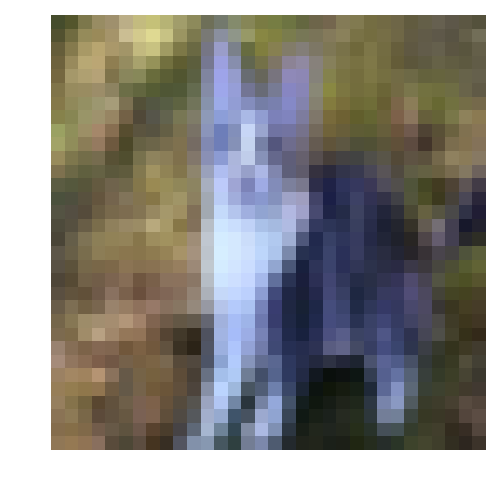

In [0]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 5
sample_id = 1021
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [0]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    x=np.array(x)
    x=x.astype(float)
    x=np.divide(x,np.max(x))
    return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_normalize(normalize)

Tests Passed


In [0]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    one_hot=[]
    x=np.array(x)
    for i in x:
        a=np.zeros(10)
        a[i]=1
        one_hot.append(a)
        
        
    # TODO: Implement Function
    return np.array(one_hot)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_one_hot_encode(one_hot_encode)

Tests Passed


In [0]:
# Preprocess Training, Validation, and Testing Data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [0]:
import pickle

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [0]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    ht=image_shape[0]
    wd=image_shape[1]
    ch=image_shape[2]
    image_shape=tf.placeholder(tf.float32,shape=[None,ht,wd,ch],name='x')
    return image_shape


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    n_classes=tf.placeholder(tf.float32,shape=[None,n_classes],name='y')
    return n_classes


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    dropout=tf.placeholder(tf.float32,shape=None,name='keep_prob')
    return dropout


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
test_nn_image_inputs(neural_net_image_input)
test_nn_label_inputs(neural_net_label_input)
test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


In [0]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernel size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernel size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    #tensor for weights with normally distributed values
    
    depth=x_tensor.get_shape().as_list()[3]
    #print(type(depth))
    wt=tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], depth, conv_num_outputs]))
    
    # tensor for bias with zero initially
    
    biases=tf.Variable(tf.zeros(conv_num_outputs))
    
    #creating convolutional layer with tensorflow
    
    conv_layer=tf.nn.conv2d(x_tensor,wt,strides=[1,conv_strides[0],conv_strides[1],1],padding='SAME')
    conv_layer=tf.nn.bias_add(conv_layer,biases)
    conv_layer=tf.nn.relu(conv_layer)
    #max pool layer
    conv_layer=tf.nn.max_pool(conv_layer,ksize=[1,pool_ksize[0],pool_ksize[1],1],strides=[1,pool_strides[0],pool_strides[1],1],padding='SAME')    
    return conv_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_con_pool(conv2d_maxpool)

Instructions for updating:
Colocations handled automatically by placer.
Tests Passed


In [0]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    dim=x_tensor.get_shape().as_list()[1]*x_tensor.get_shape().as_list()[2]*x_tensor.get_shape().as_list()[3]
    x_tensor=tf.reshape(x_tensor,[-1,dim])
    return x_tensor


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_flatten(flatten)

Tests Passed


In [0]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    dense = tf.layers.dense(inputs=x_tensor, units=num_outputs, activation=tf.nn.relu)
    return dense


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_fully_conn(fully_conn)

Instructions for updating:
Use keras.layers.dense instead.
Tests Passed


In [0]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    output = tf.layers.dense(inputs=x_tensor, units=num_outputs)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_output(output)

Tests Passed


In [0]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    con=conv2d_maxpool(x,conv_num_outputs=20,conv_ksize=(4,4),conv_strides=(1,1),pool_ksize=(6,6),pool_strides=(3,3))
    con=tf.nn.dropout(con,keep_prob)

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    
    con=flatten(con)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    
    con=fully_conn(con,350)

    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    
    con=output(con,10)
    # TODO: return output
    return con


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

test_conv_net(conv_net)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Neural Network Built!


In [0]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer,feed_dict={keep_prob:keep_probability,x:feature_batch,y:label_batch})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_train_nn(train_neural_network)

Tests Passed


In [0]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    loss=session.run(cost,feed_dict={x:feature_batch,y:label_batch,keep_prob:1})
    acc=session.run(accuracy,feed_dict={x:valid_features,y:valid_labels,keep_prob:1})
    print("cost={:.5f} \taccuracy={:.5f}".format(loss,acc))

In [0]:

# TODO: Tune Parameters
epochs = 100
batch_size = 256
keep_probability = 0.6

In [0]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  cost=2.12109 	accuracy=0.21640
Epoch  2, CIFAR-10 Batch 1:  cost=1.91193 	accuracy=0.29860
Epoch  3, CIFAR-10 Batch 1:  cost=1.85749 	accuracy=0.35760
Epoch  4, CIFAR-10 Batch 1:  cost=1.76408 	accuracy=0.39620
Epoch  5, CIFAR-10 Batch 1:  cost=1.64769 	accuracy=0.43380
Epoch  6, CIFAR-10 Batch 1:  cost=1.51285 	accuracy=0.45080
Epoch  7, CIFAR-10 Batch 1:  cost=1.40686 	accuracy=0.45920
Epoch  8, CIFAR-10 Batch 1:  cost=1.32833 	accuracy=0.47880
Epoch  9, CIFAR-10 Batch 1:  cost=1.24222 	accuracy=0.48160
Epoch 10, CIFAR-10 Batch 1:  cost=1.18726 	accuracy=0.49020
Epoch 11, CIFAR-10 Batch 1:  cost=1.09579 	accuracy=0.50260
Epoch 12, CIFAR-10 Batch 1:  cost=1.04786 	accuracy=0.50540
Epoch 13, CIFAR-10 Batch 1:  cost=1.00920 	accuracy=0.50800
Epoch 14, CIFAR-10 Batch 1:  cost=0.95996 	accuracy=0.51660
Epoch 15, CIFAR-10 Batch 1:  cost=0.91949 	accuracy=0.52140
Epoch 16, CIFAR-10 Batch 1:  cost=0.88872 	accuracy=0.525

In [0]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  cost=2.17029 	accuracy=0.21600
Epoch  1, CIFAR-10 Batch 2:  cost=1.82587 	accuracy=0.35980
Epoch  1, CIFAR-10 Batch 3:  cost=1.61249 	accuracy=0.38100
Epoch  1, CIFAR-10 Batch 4:  cost=1.69017 	accuracy=0.42760
Epoch  1, CIFAR-10 Batch 5:  cost=1.50211 	accuracy=0.44320
Epoch  2, CIFAR-10 Batch 1:  cost=1.68672 	accuracy=0.46880
Epoch  2, CIFAR-10 Batch 2:  cost=1.38590 	accuracy=0.48000
Epoch  2, CIFAR-10 Batch 3:  cost=1.24633 	accuracy=0.47200
Epoch  2, CIFAR-10 Batch 4:  cost=1.35056 	accuracy=0.49680
Epoch  2, CIFAR-10 Batch 5:  cost=1.27642 	accuracy=0.50440
Epoch  3, CIFAR-10 Batch 1:  cost=1.48831 	accuracy=0.51440
Epoch  3, CIFAR-10 Batch 2:  cost=1.20056 	accuracy=0.51180
Epoch  3, CIFAR-10 Batch 3:  cost=1.06862 	accuracy=0.51800
Epoch  3, CIFAR-10 Batch 4:  cost=1.15976 	accuracy=0.52860
Epoch  3, CIFAR-10 Batch 5:  cost=1.15605 	accuracy=0.53400
Epoch  4, CIFAR-10 Batch 1:  cost=1.33598 	accuracy=0.53200
Epoch  4, CIFAR-10 Batch 2: 

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.66953125



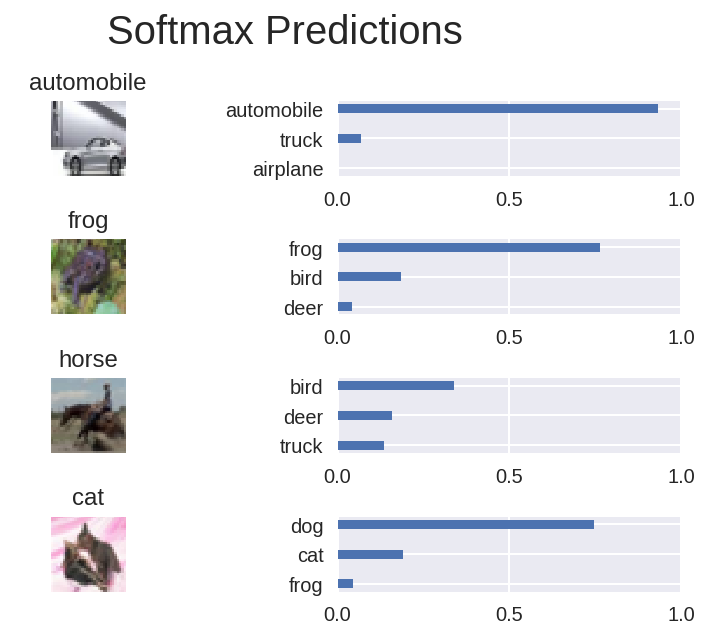

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()